In [1]:
# import thư viện numpy
import numpy as np
# import thư viện matplotlib
import matplotlib.pyplot as plt

import scipy.sparse as sp

import math

from numpy import linalg as LA

# Tải dữ liệu data X và y đã được xử lý thành ma trận
labels = np.load('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/label.npy')
# dữ liệu bình thường dùng hàm tách
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/tfidf.npz')

# dữ liệu tf_idf loại bỏ stop words
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/tf_idf_processed_data_sw.npz')
# dữ liệu tf_idf không loại bỏ stop words
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/tf_idf_processed_data_pt.npz')

# dữ liệu boolean loại bỏ stop words
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/boolean_processed_data_sw.npz')
# dữ liệu boolean không loại bỏ stop words
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/boolean_processed_data_pt.npz')

# dữ liệu tf loại bỏ stop words
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/tf_processed_data_sw.npz')
# dữ liệu tf không loại bỏ stop words
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/tf_processed_data_pt.npz')

# dữ liệu idf loại bỏ stop words
features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/idf_processed_data_sw.npz')
# dữ liệu idf không loại bỏ stop words
# features = sp.load_npz('C:/Users/Admin/Downloads/NLTK_is_Sarcastic-master/PreProcessed_Data/idf_processed_data_pt.npz')

def add_bias(features, labels):
    '''
    features là ma trận N*X với N là số datapoint, X là số term trong dictionary
    labels là ma trận N*1 với N là số datapoint
    
    Hàm trả về ma trận features(sau khi đã thêm 1 cột bias giá trị 1 cho tất cả các phần tử) và labels
    '''
    # Thêm cột giá trị bias cho dữ liệu
    labels_final = sp.csr_matrix(labels, shape = (1, len(labels)))
    matrix_ones = sp.csc_matrix((26709,1),dtype=np.float)
    matrix_ones[:]=1
    matrix_final_features= sp.csc_matrix(sp.hstack((features,matrix_ones)))
    return matrix_final_features, labels_final

# chia Train và test
matrix_final_features, labels_final = add_bias(features, labels)
X_Train = matrix_final_features[:20000]
X_test = matrix_final_features[20000:]
y_Train = labels_final.T[:20000]
y_test = labels_final.T[20000:]

C:\Users\Admin\Anaconda3\envs\NEW\lib\site-packages\ipykernel_launcher.py:47: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.


# Hàm Sigmoid

In [2]:
def sigmoid(z):
    # hàm sigmoid
    '''
    z là model đầu ra Linear Regression
    np.exp là e mũ
    Hàm trả về sigmoid của z
    
    '''
    return 1/(1+np.exp(-z))

# Hàm Cost Function

In [3]:
def Cost_Function(w, y, X):
    '''
    w là ma trận bộ tham số có shape bằng (1,X.shape[1])
    X là features
    y là y labels
    Hàm trả về cost tương ứng bộ tham số w
    
    '''
    # tính giá trị đầu ra của hàm Linear Regression
    s = X.dot(w).toarray()
    # scale s về khoảng [0,1] dùng hàm sigmoid
    # z là xác xuất điểm dữ liệu rơi vào lớp y
    z = sigmoid(s)
    y = y.toarray()
    
    cost = -np.sum((y*(np.log(z)) + (1-y)*np.log(1-z)))/ X.shape[0]
    
    return cost

# Hàm tính đạo hàm 

In [4]:
def Derivative(w, y, X):
    '''
    W là ma trận bộ trọng số w: (28901, 1)  <class 'scipy.sparse.csc.csc_matrix'>
    y là dữ liệu labels y: (1, 1) <class 'scipy.sparse.csc.csc_matrix'>
    X là dữ liệu Train X: (28901, 1) <class 'scipy.sparse.csr.csr_matrix'>
    
    Hàm trả về giá trị đạo hàm của Cost theo từng w
    '''
    # tính giá trị đầu ra của hàm Linear Regression
    s = X.dot(w).toarray()
    # scale s về khoảng [0,1] dùng hàm sigmoid
    # z là xác xuất điểm dữ liệu rơi vào lớp y
    z = sigmoid(s)
    y = y.toarray()
#     print('z',z.shape, type(z))
#     print('y',y.shape, type(y))
#     print('X',X.shape, type(X))
    der = (z-y).T
    
    X = X.T
#     print(X.shape, type(X))
    der = sp.csr_matrix(der, shape = (1,der.shape[1]))
    der = der.T
#     print(der.shape, type(der))
    
    return X.dot(der)

# Khởi tạo Learning Rate

In [5]:
# Khởi tạo learning rate
alpha = 0.0005

# Prediction

In [6]:
def Prediction(w, y, X, thred):
    '''
    W là ma trận bộ trọng số w: (28901, 1)  <class 'scipy.sparse.csc.csc_matrix'>
    y là dữ liệu labels y: (1, 1) <class 'scipy.sparse.csc.csc_matrix'>
    X là dữ liệu Train X: (28901, 1) <class 'scipy.sparse.csr.csr_matrix'>
    
    Hàm trả về ma trận N*1 với N là số datapoint
    '''
     # tính giá trị đầu ra của hàm Linear Regression
    s = X.dot(w).toarray()
    # scale s về khoảng [0,1] dùng hàm sigmoid
    # z là xác xuất điểm dữ liệu rơi vào lớp y
    z = sigmoid(s)
    for i in range(z.shape[0]):
        if(z[i]>thred):
            z[i] = 1
        else: z[i] = 0
    return z

In [7]:
# Khởi tạo ma trận biến với giá trị khởi tạo tại mỗi phần tử là 0
w = np.zeros((X_Train.shape[1], 1))
w = sp.csc_matrix(w, shape = (len(w),1))

# BGD 

epoch =  0 cost =  0.5415683919235855
epoch =  500 cost =  0.026021894426745688


C:\Users\Admin\Anaconda3\envs\NEW\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\Admin\Anaconda3\envs\NEW\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()


Cost trên tập test_data: 0.7930091015239592


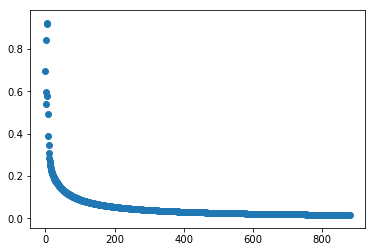

In [8]:
# list chứa tất cả mse
all_Cost = []

# Khởi tạo số vòng lặp
i = 0
# Huấn luyện
while True:
    # Tính cost với w hiện thời
    err = Cost_Function(w, y_Train, X_Train)
    all_Cost.append(err)
    # Cập nhật w theo công thức gradient descent
    der = Derivative(w, y_Train, X_Train)
    w = w - alpha*der 
   
    if i % 500 == 0:
        # In ra cost tại vòng lặp thứ i
        print("epoch = ", i, "cost = ",Cost_Function(w, y_Train, X_Train))
    i += 1
    if math.isnan(float(err)) or (LA.norm(der.toarray())/ der.shape[0]) == 0:
        break
    

# kiểm tra trên tập test
print("Cost trên tập test_data:", Cost_Function(w, y_test, X_test))
# Vẽ đồ thị biễu diễn cost qua từng vòng lặp
axis_x = list(range(i))
axis_y = all_Cost
plt.scatter(axis_x, axis_y)
plt.show()

In [10]:
y_pred = Prediction(w, y_test, X_test, 0.5)

In [11]:
# tính tổng số điểm dữ liệu dự đoán có nhãn là 1 đúng
def find_TP(y_pred, y_test):
    count = 0
    Positive = np.multiply(y_pred, y_test)
    return np.count_nonzero(Positive)
TP = find_TP(y_pred, y_test.toarray())

# tính tổng số điểm dữ liệu dự đoán nhãn là 1 nhưng sai
def find_FP(y_pred, y_test):
    count = 0
    for i in range(y_pred.shape[0]):
        if y_pred[i] == 1:
            if y_test[i] == 0:
                count += 1
    return count
FP = find_FP(y_pred, y_test.toarray())

# tính tống số điểm dữ liệu có nhãn là 1 trong tập test
def find_P(y_pred, y_test):
    return np.count_nonzero(y_test)
P = find_P(y_pred, y_test.toarray())

print('TP:', TP)
print('FP:', FP)
print('P:', P)

TP: 2016
FP: 578
P: 2930


# Valuate

In [12]:
from Evaluate import *
Re = Recall(TP, P)
Pr = Precision(TP, FP)
print('Accuracy = ',Accuracy(y_pred, y_test.toarray()))
print("Precision score =", Pr)
print("Recall score:", Re)
print("F1_score:",F1_score(Pr, Re))

Accuracy =  0.7776121627664332
Precision score = 0.7771781033153431
Recall score: 0.6880546075085324
F1_score: 0.729905865314989
